In this notebook, we are interested in unsupervised learning. The goal in particular is to learn a linear projection of feature matrices retaining the largest fraction of information from the original matrix.

In [2]:
# Load the required libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
from matplotlib.image import imread
#import skimage

# Compression with SVD

SVD constitutes the most basic method to reduce the dimensionality of a feature matrix $X\in\mathbb{R}^{d\times n}$ by seeking a rank-$k$ ($k < d$) linear projection with the smallest Frobenius (or spectral) norm. Mathematically, we are looking for $\hat{X}\in\mathbb{R}^{k\times n}$ satisfying
\begin{equation}
\min_{\mathrm{rk}(\hat{X})\leq k} \lVert X - \hat{X}\rVert_F^2,
\end{equation}
where $\mathrm{rk}(A)$ is the rank of $A$.
According to the **Eckart-Young theorem**, the global minimum of this optimization problem is reached for $\hat{X}$ given by the Singular Value Decomposition (SVD) of $X$, and retaining only the components associated to the $k$ largest singular values.

SVD states that any matrix $X$ can be decomposed as a set of three matrices
\begin{equation}
X = U S V^\mathrm{T},
\end{equation}
where $U$ and $V$ are orthonormal matrices ($U^\mathrm{T}U = V^\mathrm{T}V = I$), and
- $U \in \mathbb{R}^{d\times d}$ contains in columns the eigenvectors of $XX^\mathrm{T}$,
- $V \in \mathbb{R}^{n\times n}$ contains in columns the eigenvectors of $X^\mathrm{T}X$,
- $S \in \mathbb{R}^{d\times n}$ is a diagonal matrix containing the singular values $s_i$.

2 results about SVD are of importance for what follows. First, since both $S_\mathrm{L} = XX^\mathrm{T}$ and $S_\mathrm{R} = X^\mathrm{T}X$ are positive-definite matrices, all their eigenvalues are positive ($\forall i, \lambda_i^\mathrm{L} \geq 0, \lambda_i^\mathrm{R} \geq 0$). Second, if we order the eigenvalues of both matrices, then they are the same up to the order $m=\min(n,d)$. Above $m$, all the eigenvalues can be shown to be exactly zero. The singular values are defined as $s_i = \sqrt{\lambda_i^\mathrm{L}}$.

A more 'memory-efficient' (but equivalent) result takes only $m$ columns in $U$ and $V$, therefore removing the zero singular values.

#### How to find the singular values?

Let us focus on first on finding a rank-one approximation of a matrix $X$. Any rank-one matrix can be written as $\sigma u v^\mathrm{T}$. Then the goal is to solve
\begin{equation}
\operatorname*{argmin}_{\sigma, v, u} \lVert X - \sigma u v^\mathrm{T} \rVert^2_F,
\end{equation}
under the constraint that $\lVert u \rVert = \lVert v \rVert = 1$.

0. Perform this minimization. How would you then get a rank-two approximation and what would it give for $u_2$, $v_2$, and $\sigma_2$? Comment.

Let us first perform SVD of a single image of size $2000\times 1500$ taken from the ```DATA``` folder called ```dog.jpg```.


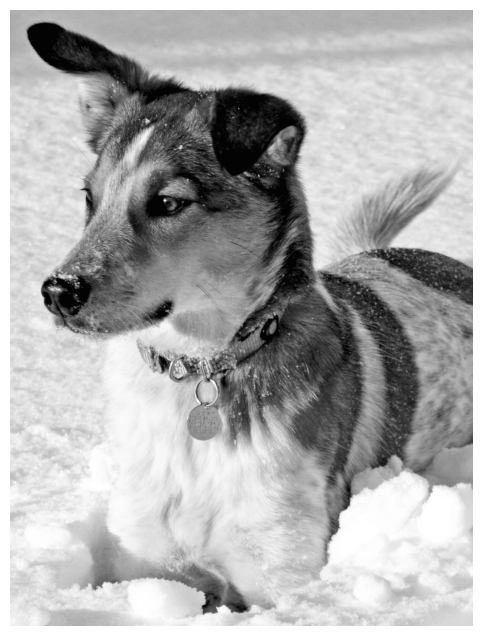

In [3]:
plt.rcParams['figure.figsize'] = [16, 8]


A = imread(os.path.join('.','DATA','dog.jpg')) # Load the image
X = np.mean(A, -1); # Convert RGB to grayscale

img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()

1. Checkout the [`np.linalg.svd`](https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.linalg.svd.html) function, and **use it to decompose the input image $X$**. We will be using the 'full_matrices=False' option so that the matrices takes less memory space. **Check that the SVD gives back the full matrix.**

In [179]:
# Your code to perform SVD
U, S, VT = np.linalg.svd(X, full_matrices=False)

# Your code to check the shapes
print('Data shape = ' + str(X.shape))
print('U shape = ' + str(U.shape))
print('S shape = ' + str(S.shape))
print('VT shape = ' + str(VT.shape))

# Let's transform S into a matrix
S = np.diag(S)
print('new S shape = ' + str(S.shape))

print('X=USV.T? ' + str(np.sum(np.mean(X-U@S@VT, axis=1)) < 1e-6 ))

Data shape = (2000, 1500)
U shape = (2000, 1500)
S shape = (1500,)
VT shape = (1500, 1500)
new S shape = (1500, 1500)
X=USV.T? True


2. Explore the compression with several values $r$ of singular values. **Explain what you get when varying $r$.**

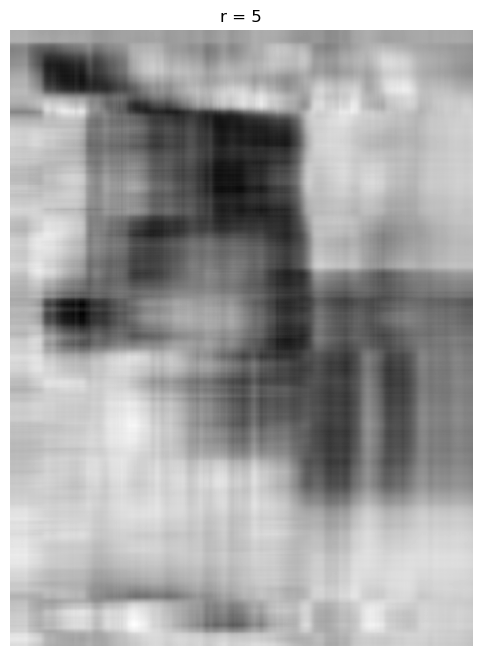

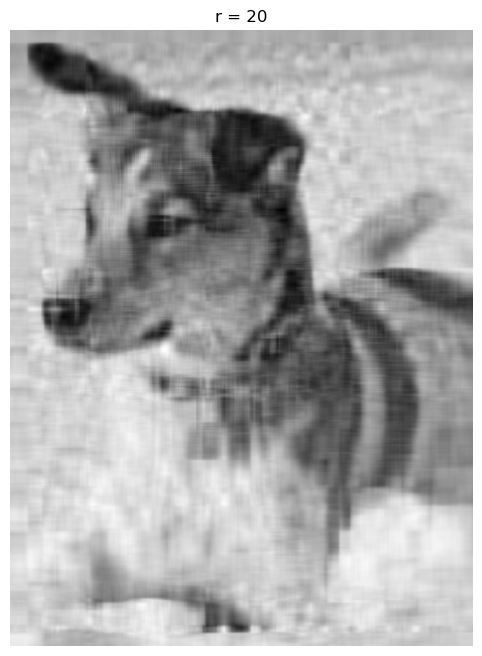

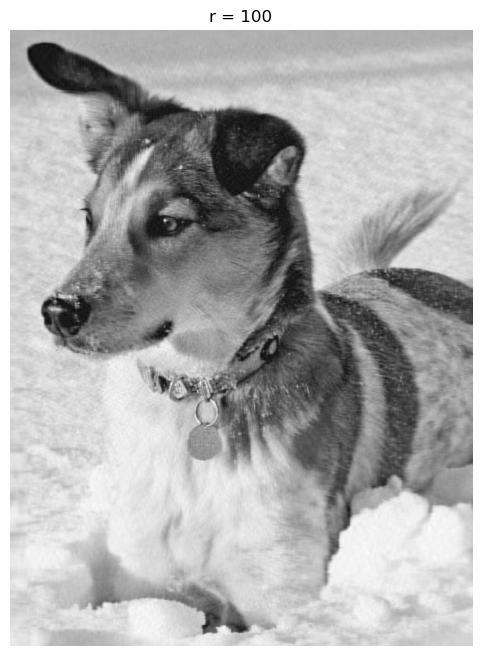

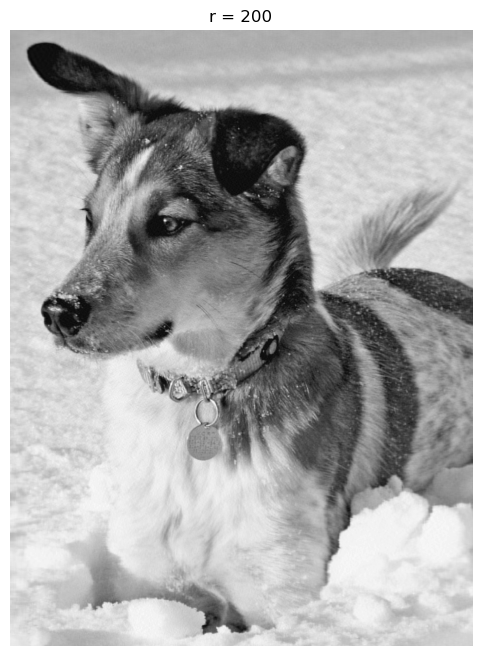

In [181]:
j = 0
for r in (5, 20, 100, 200):
    Xapprox = U[:,:r] @ S[0:r,:r] @ VT[:r,:] # Your code to construct the approximation
    plt.figure(j+1)
    j += 1
    img = plt.imshow(Xapprox)
    img.set_cmap('gray')
    plt.axis('off')
    plt.title('r = ' + str(r))
    plt.show()

3. Compute the cumulative sum of singular values, **how many dimensions are required to retain $80\%$ of the cumulative sum?**

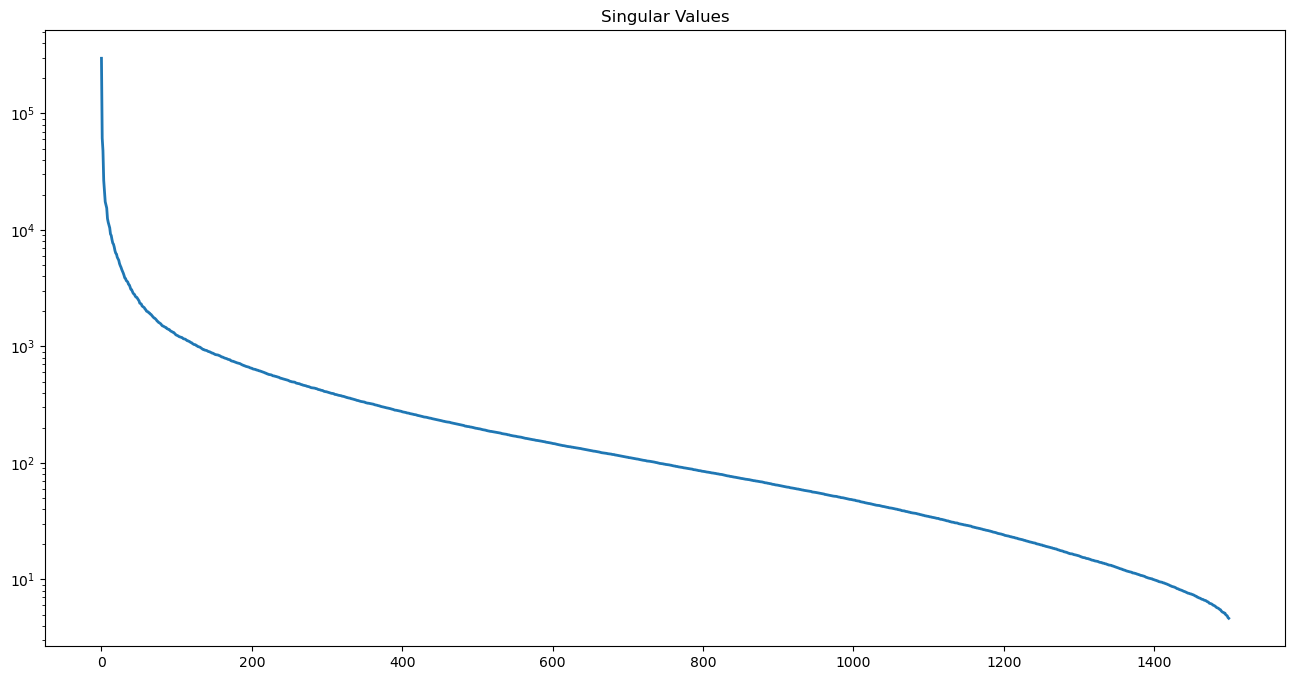

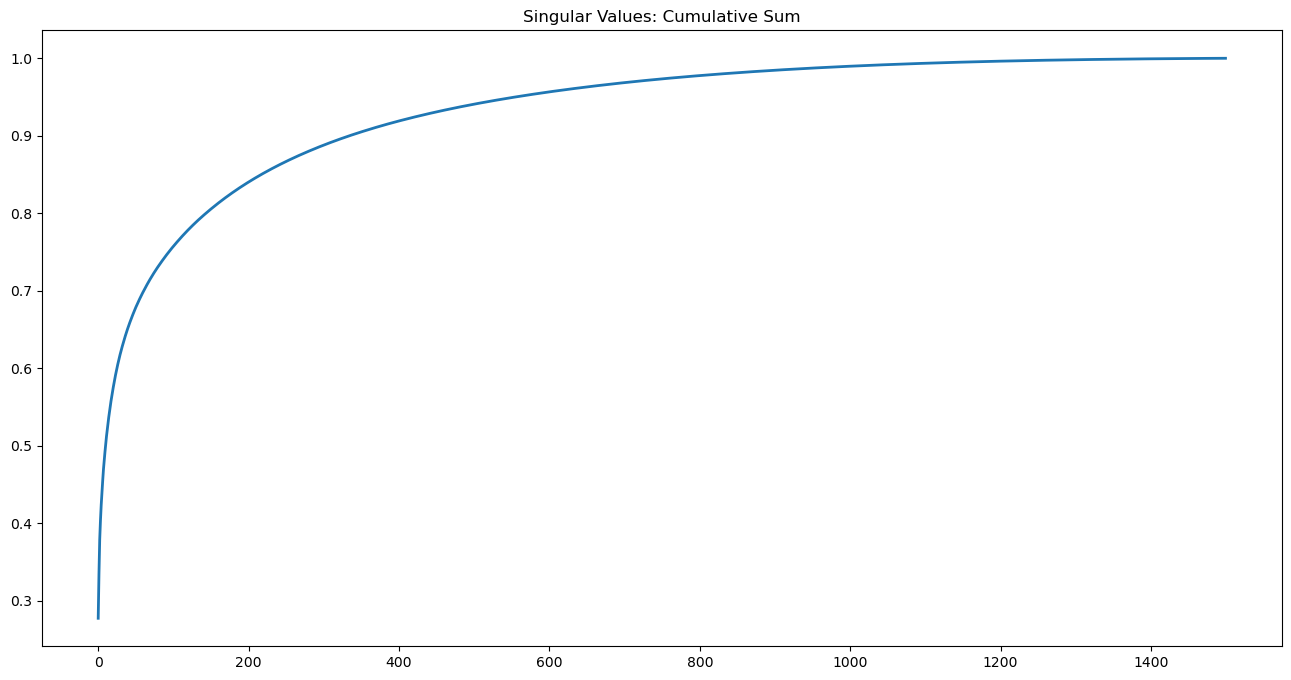

144

In [182]:
# Your code to plot and compute the cumulative sum of singular values
plt.figure(1)
plt.semilogy(np.diag(S), lw=2)
plt.title('Singular Values')
plt.show()

cumsum = np.cumsum(np.diag(S))/np.sum(np.diag(S))
plt.figure(2)
plt.plot(cumsum, lw=2)
plt.title('Singular Values: Cumulative Sum')
plt.show()

np.where(cumsum > 0.8)[0][0]

# [Eigenface](https://en.wikipedia.org/wiki/Eigenface)

The Eigenface dataset is a collection of facial images used computer vision and pattern recognition, particularly for facial recognition tasks. 
Here, we use a subset of it contained in the folder ```DATA/allFaces.mat```. It consists of facial images of $n = 38$ individuals under between 59 and 64 lighting conditions. Each image is $192\times168$, hence contains $32,256$ pixels.

In [4]:
# Load the images
mat_contents = scipy.io.loadmat(os.path.join('.','DATA','allFaces.mat'))
print(mat_contents.keys())
faces = mat_contents['faces']
W = int(mat_contents['m'])
L = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])
print(L, W)

dict_keys(['__header__', '__version__', '__globals__', 'faces', 'n', 'm', 'sub', 'nfaces', 'person'])
192 168


In [5]:
# print the number of faces (lighting conditions) per individuals
print(nfaces)
print(faces.shape)

[64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64]
(32256, 2410)


The list above gives the number of different lightings for each individual.
We will use the 36 first individuals as the training data, and keep the two last as test data.

Let us now plot the different images for each individual.

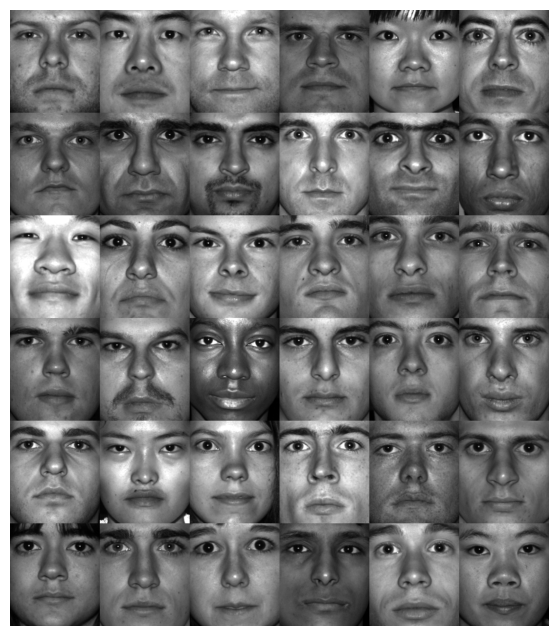

In [6]:
allPersons = np.zeros((L*6,W*6))
count = 0

for j in range(6):
    for k in range(6):
        allPersons[j*L : (j+1)*L, k*W : (k+1)*W] = np.reshape(faces[:,np.sum(nfaces[:count])],(W,L)).T
        count += 1

img = plt.imshow(allPersons)
img.set_cmap('gray')
plt.axis('off')
plt.show()

Now we check for the first few persons the different ligthing conditions.

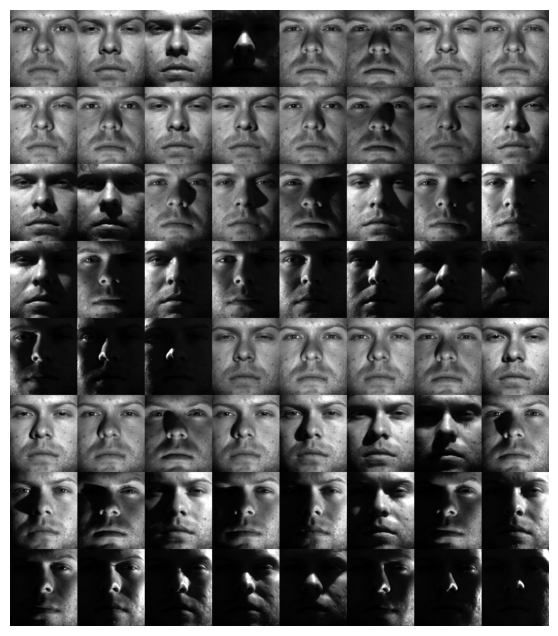

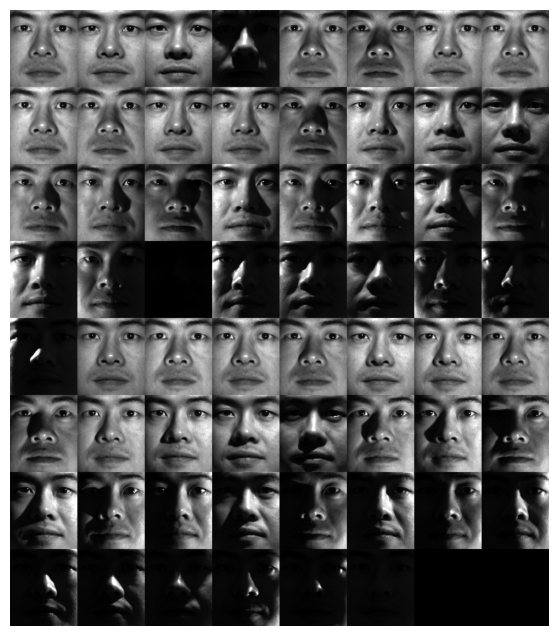

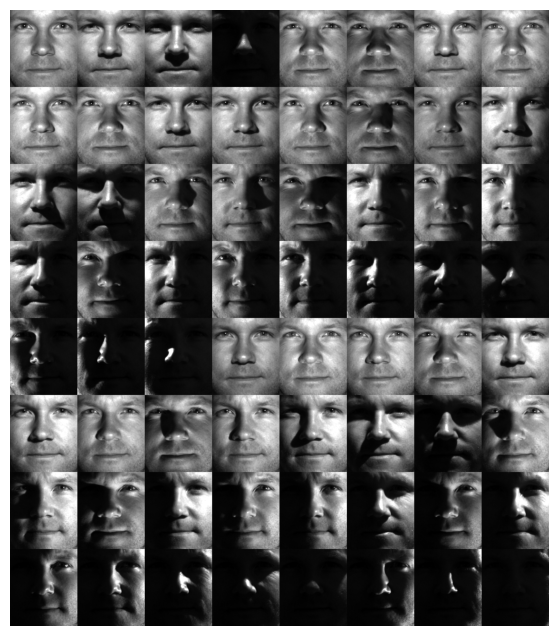

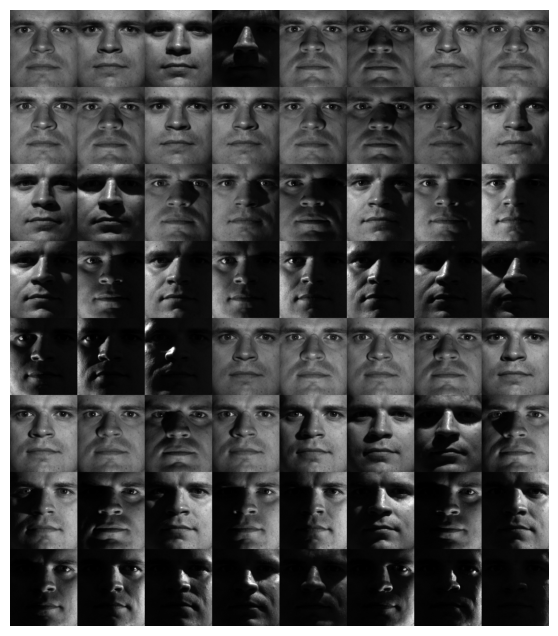

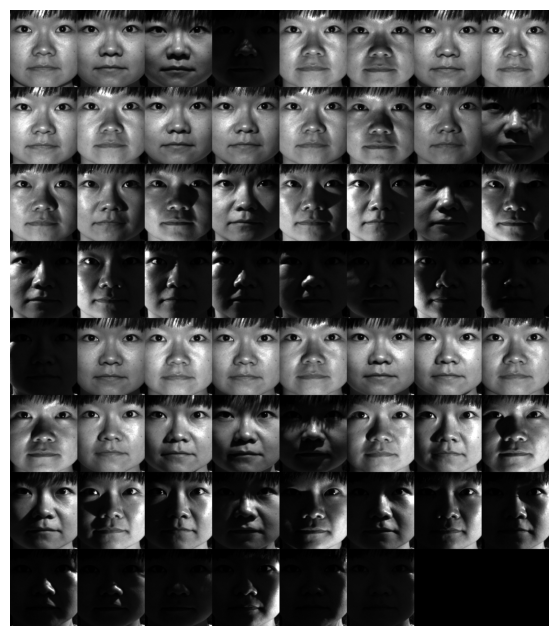

In [10]:
for person in range(0, 5): #len(nfaces)
    subset = faces[:,sum(nfaces[:person]) : sum(nfaces[:(person+1)])]
    allFaces = np.zeros((L*8,W*8))
    
    count = 0
    
    for j in range(8):
        for k in range(8):
            if count < nfaces[person]:
                allFaces[j*L:(j+1)*L,k*W:(k+1)*W] = np.reshape(subset[:,count],(W,L)).T
                count += 1
                
    img = plt.imshow(allFaces)
    img.set_cmap('gray')
    plt.axis('off')
    plt.show()

4. Center the training dataset along the pixel dimension. **Visualise the average face**.

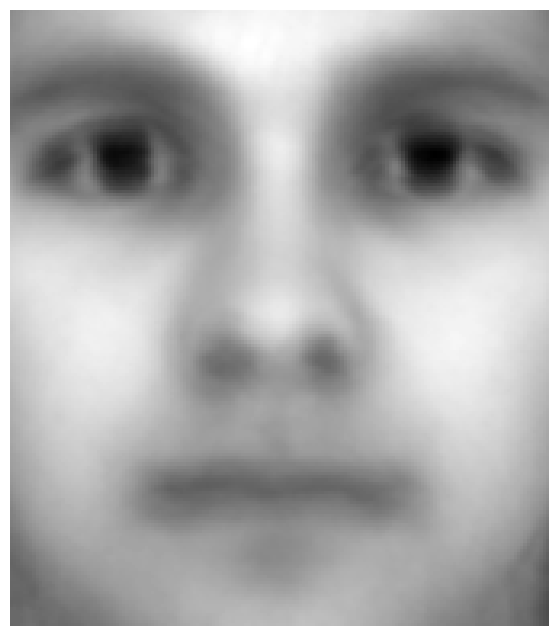

In [189]:
# We use the first 36 people for training data
# We first compute the average face
trainingFaces = faces[:, :np.sum(nfaces[:36])] # size L*W=32256 by 2282
avgFace = np.mean(trainingFaces, axis=1)       # size L*W by 1

# Center the training dataset along each pixel
X = trainingFaces -  avgFace[:,np.newaxis]
assert np.sum(np.mean(X, axis=1)) < 1e-6

# Plot the average face
plt.imshow(np.reshape(avgFace,(W,L)).T)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

5. Perform SVD on the centered dataset to find the matrices $U$, $S$, and $V$ that we will use to project the data. **What matrix should we use for projections? Visualise some eigenfaces (columns of the said matrix).**

In [190]:
# Your code to perform SVD on the training data
#%%time
U, S, VT = np.linalg.svd(X, full_matrices=0) # U is 32256x2282 VT is 2282x2282

Data shape = (32256, 2282)
U shape = (32256, 2282)
S shape = (2282,)
VT shape = (2282, 2282)


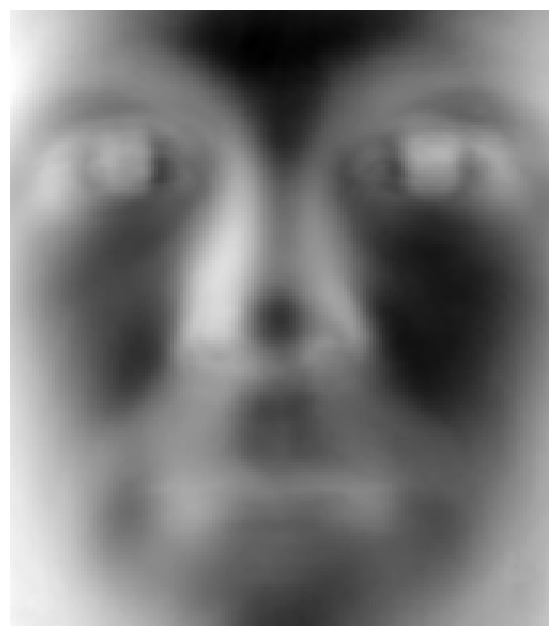

In [191]:
# Your code to check the shapes and visualise a mode of the SVD
print('Data shape = ' + str(X.shape))
print('U shape = ' + str(U.shape))
print('S shape = ' + str(S.shape))
print('VT shape = ' + str(VT.shape))

plt.imshow(np.reshape(U[:,0],(W,L)).T)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

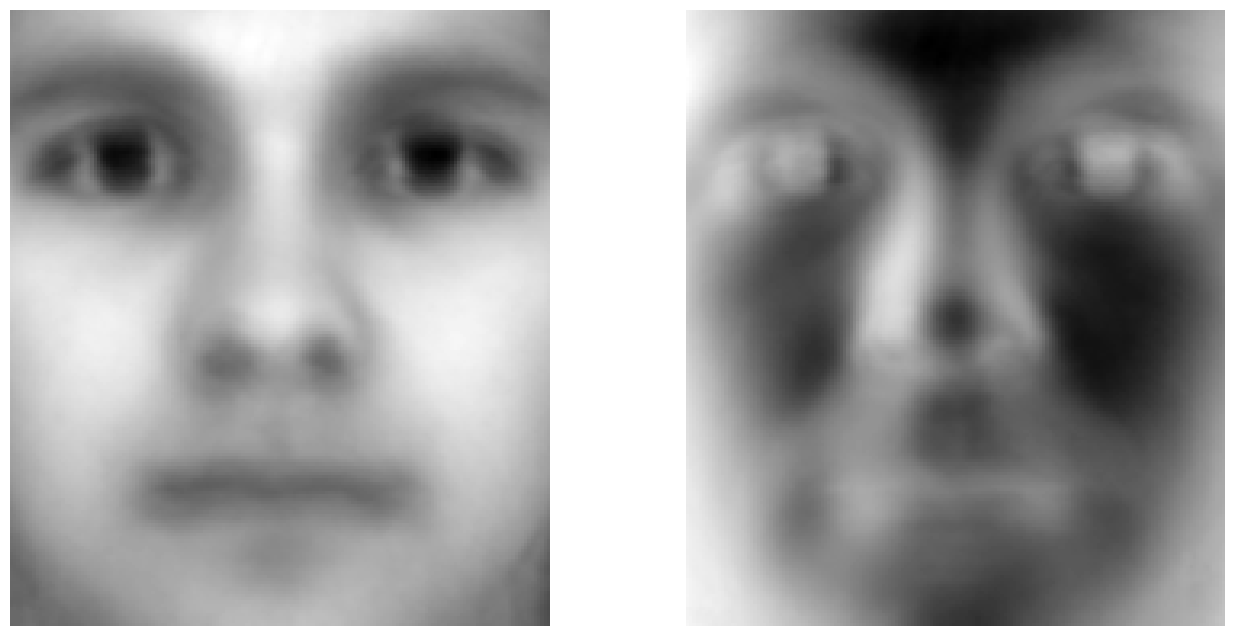

In [192]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avgFace,(W,L)).T)
img_avg.set_cmap('gray')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(U[:,0],(W,L)).T)
img_u1.set_cmap('gray')
plt.axis('off')
plt.show()

Below we plot the first 100 eigenfaces.

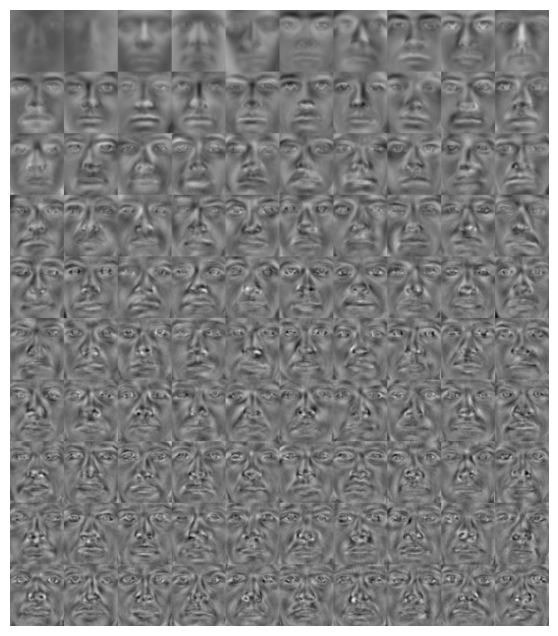

In [193]:
MATRIX_CHOICE = U # Your choice of matrix
FirstEF = np.zeros((L*10,W*10))
count = 0
for j in range(10):
    for k in range(10):
        FirstEF[j*L : (j+1)*L, k*W : (k+1)*W] = np.reshape(MATRIX_CHOICE[:,count],(W,L)).T
        count += 1
        
img = plt.imshow(FirstEF)
img.set_cmap('gray')
plt.axis('off')
plt.show()

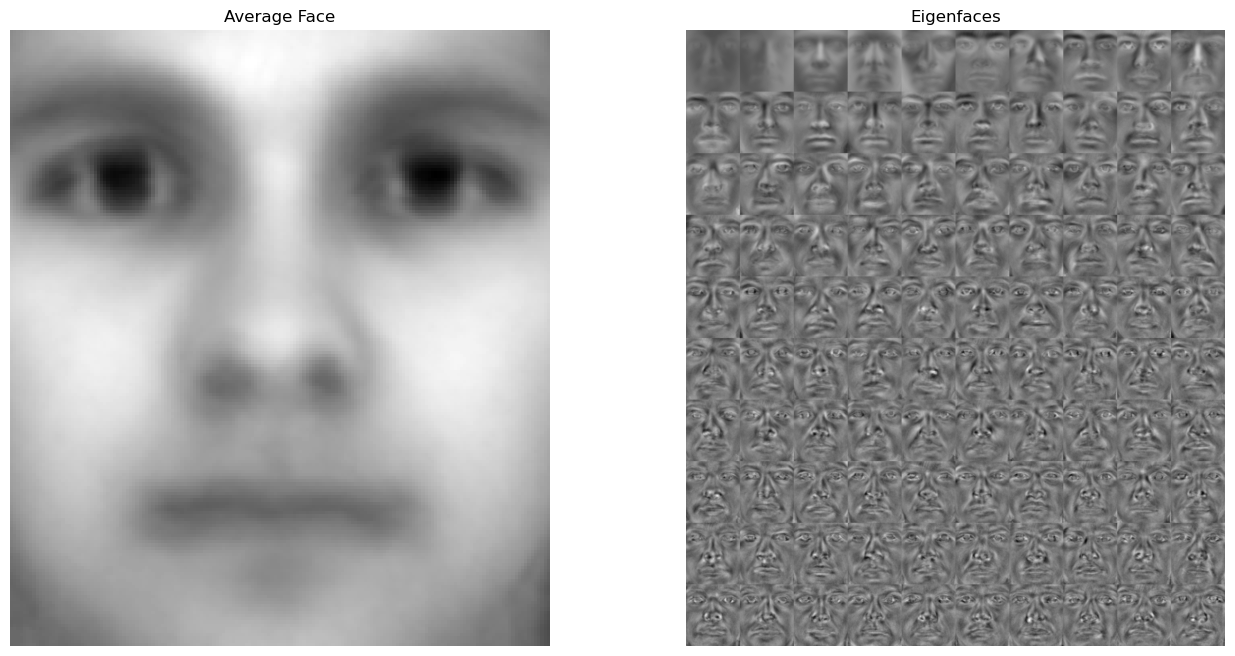

In [194]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avgFace,(W,L)).T)
img_avg.set_cmap('gray')
ax1.set_title('Average Face')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(FirstEF)
img_u1.set_cmap('gray')
plt.axis('off')
ax2.set_title('Eigenfaces')
plt.show()

6. Compute the eigenface reconstruction for various order $r$. Comment.

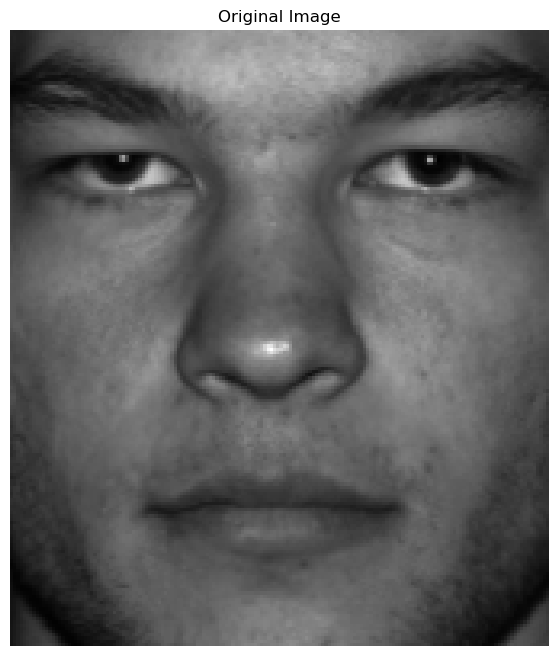

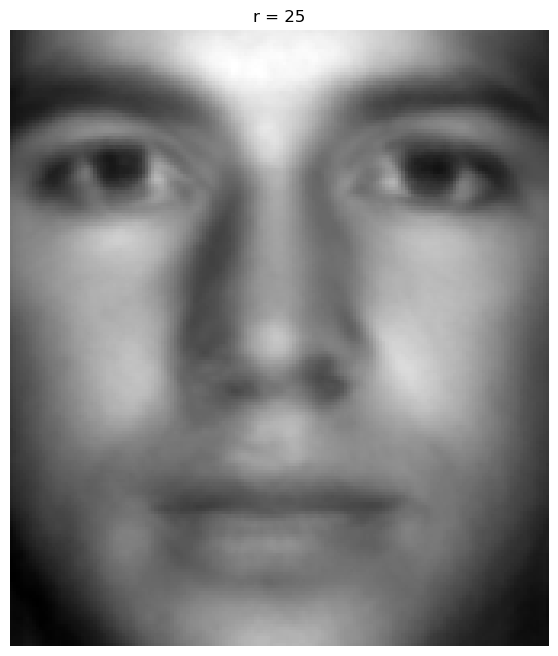

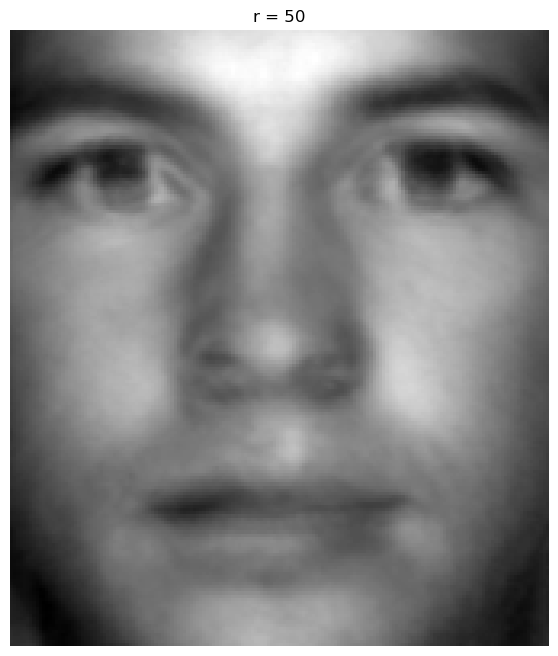

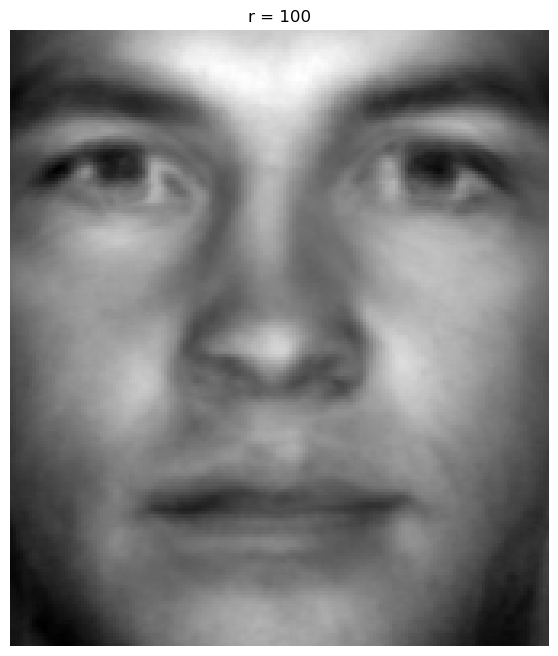

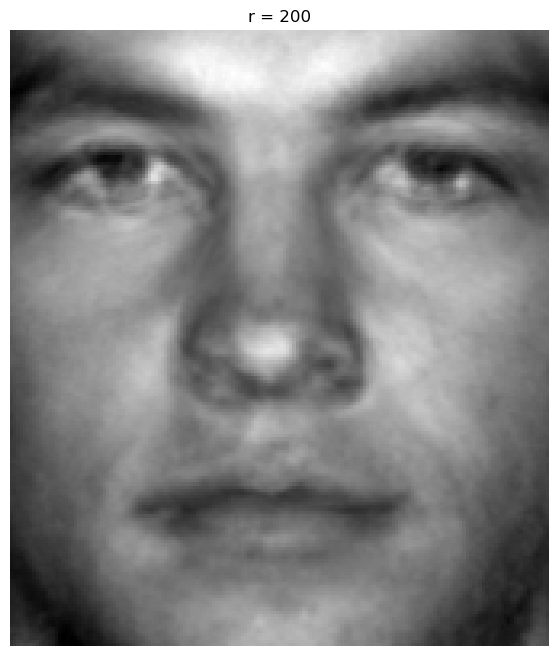

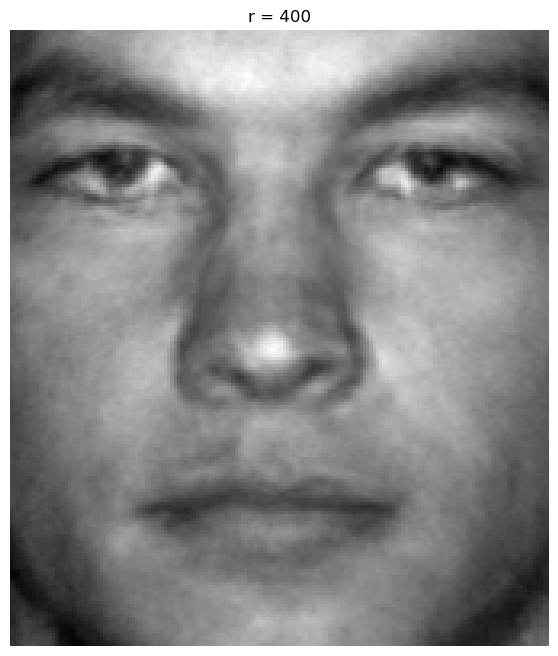

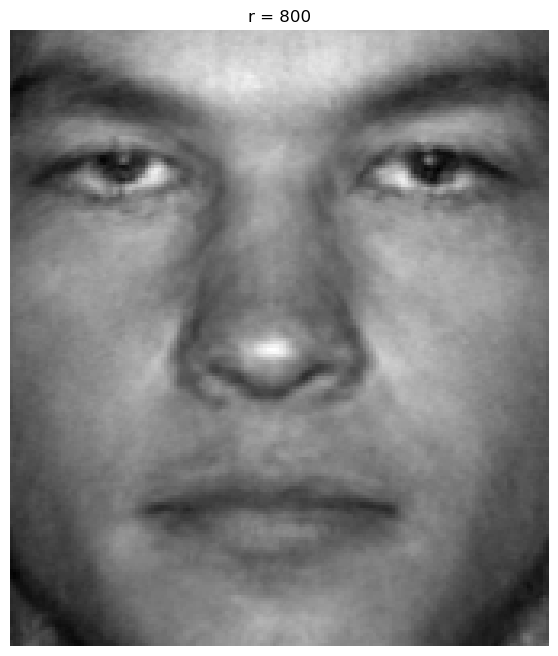

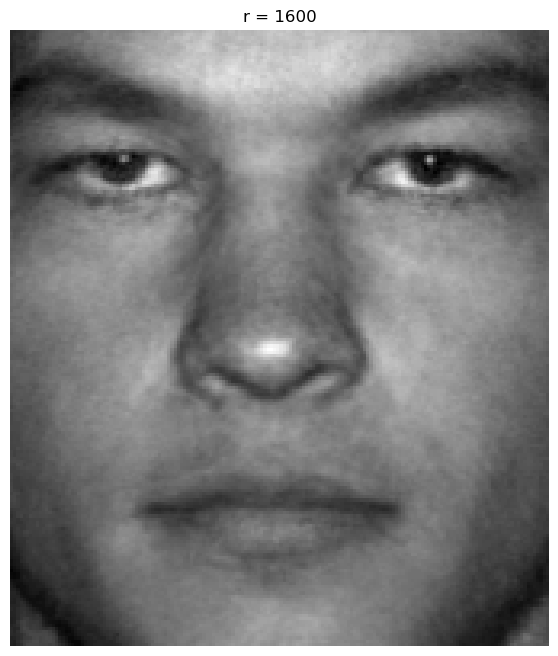

In [195]:
## Now show eigenface reconstruction of image that was omitted from test set

testFace = faces[:,np.sum(nfaces[:36])] # First face of person 37
plt.imshow(np.reshape(testFace,(W,L)).T)
plt.set_cmap('gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

testFaceMS = testFace - avgFace
r_list = [25, 50, 100, 200, 400, 800, 1600]

for r in r_list:
    reconFace = avgFace + U[:,:r] @ U[:,:r].T @ testFaceMS # Your code to reconstruct the face
    img = plt.imshow(np.reshape(reconFace,(W,L)).T)
    img.set_cmap('gray')
    plt.title('r = ' + str(r))
    plt.axis('off')
    plt.show()

7. What do you think would happen for an image that is not a face at all? Test your intuition with the dog image from the beginning that we rescale below to the same size.

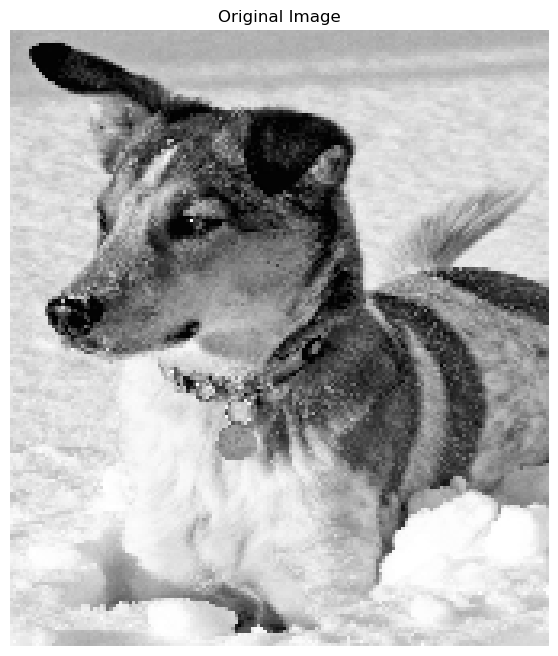

In [201]:
import cv2
img = cv2.imread(os.path.join('.','DATA','dog.jpg'))
res = cv2.resize(img, dsize=(168, 192), interpolation=cv2.INTER_CUBIC)
X_s = np.mean(res, -1); # Convert RGB to grayscale

testFace = np.reshape(X_s.T,(-1,))
plt.imshow(np.reshape(testFace,(W,L)).T)
plt.set_cmap('gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

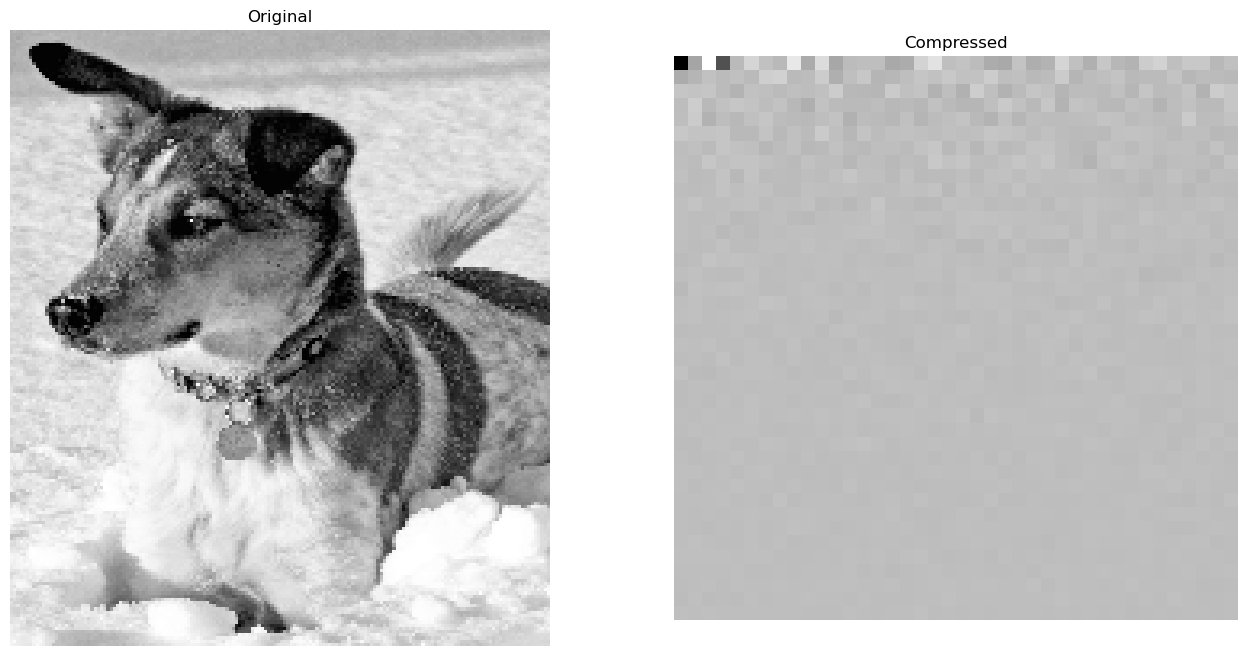

In [202]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(testFace,(W,L)).T)
img_avg.set_cmap('gray')
ax1.set_title('Original')
plt.axis('off')
r = 1600
compressed = U[:,:r].T @ testFaceMS

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(compressed,(40,40)))
img_u1.set_cmap('gray')
plt.axis('off')
ax2.set_title('Compressed')
plt.show()

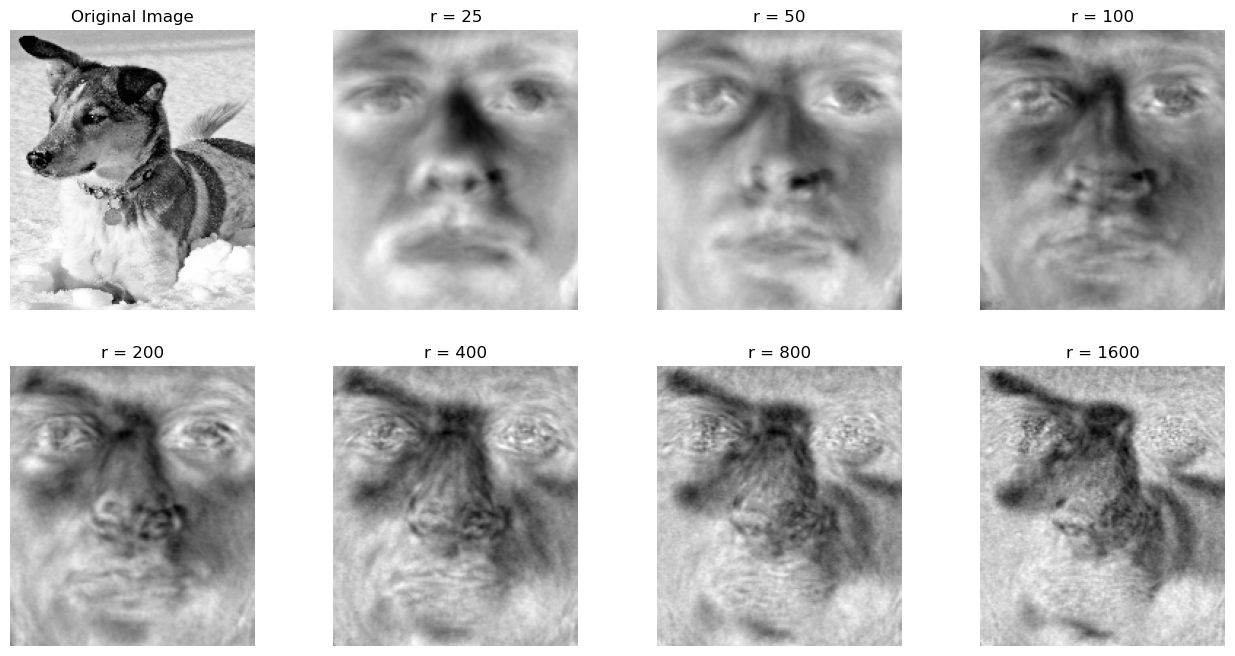

In [204]:
# Your code to reconstruct the new test image for various r
fig, axs = plt.subplots(2,4)

testFace = np.reshape(X_s.T,(-1,))
axs[0,0].imshow(np.reshape(testFace,(W,L)).T)
plt.set_cmap('gray')
axs[0,0].set_title('Original Image')
axs[0,0].axis('off')

testFaceMS = testFace - avgFace

r_list = [25, 50, 100, 200, 400, 800, 1600]

for (i,r) in enumerate(r_list):
    l = (i+1)//4
    j = (i+1)%4
    reconFace = avgFace + U[:,:r]  @ U[:,:r].T @ testFaceMS
    axs[l,j].imshow(np.reshape(reconFace,(W,L)).T)
    plt.set_cmap('gray')
    axs[l,j].set_title('r = ' + str(r))

    axs[l,j].axis('off')
    
plt.show()

This kind of singular value decomposition is in fact very much used to recognize faces of different person. By projecting faces (with different light conditions or orientations, etc.) in the appropriate subspace, we suppress the 'noisy' variability in the data and retain only the essential information of the face. In the subspace, we can therefore compare two images and decide whether it is the same person.

8. Explore this idea by projecting two persons (say 2 and 7) in a 2D SVD space (say modes 4 and 5).

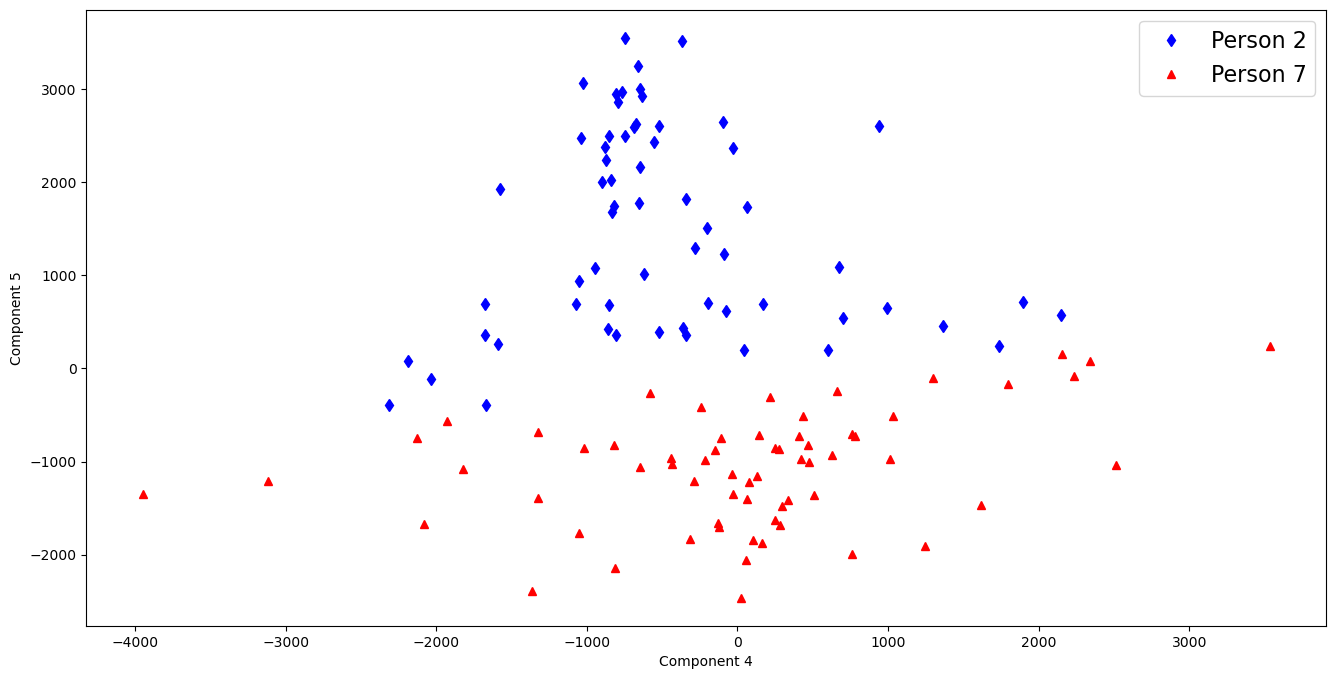

In [235]:
## Project person 2 and 7 onto PC5 and PC6

P1num = 2 # Person number 2
P2num = 7 # Person number 7

P1 = faces[:,np.sum(nfaces[:(P1num-1)]):np.sum(nfaces[:P1num])] # Selects all the faces from Person n°P1num
P2 = faces[:,np.sum(nfaces[:(P2num-1)]):np.sum(nfaces[:P2num])] # Selects all the faces from Person n°P2num

# Your code to remove the average and project onto PCA modes
PCAmodes = [4, 5] # Project onto PCA modes 4 and 5

P1 = P1 - np.tile(avgFace,(P1.shape[1],1)).T
P2 = P2 - np.tile(avgFace,(P2.shape[1],1)).T
PCACoordsP1 = U[:,PCAmodes].T @ P1
PCACoordsP2 = U[:,PCAmodes].T @ P2

plt.plot(PCACoordsP1[0,:],PCACoordsP1[1,:],'d',color='blue',label='Person {:d}'.format(P1num))
plt.plot(PCACoordsP2[0,:],PCACoordsP2[1,:],'^',color='red',label='Person {:d}'.format(P2num))
plt.xlabel(r'Component {:d}'.format(PCAmodes[0]))
plt.ylabel(r'Component {:d}'.format(PCAmodes[1]))

plt.legend(fontsize=16)
plt.show()

# Importance of data alignment

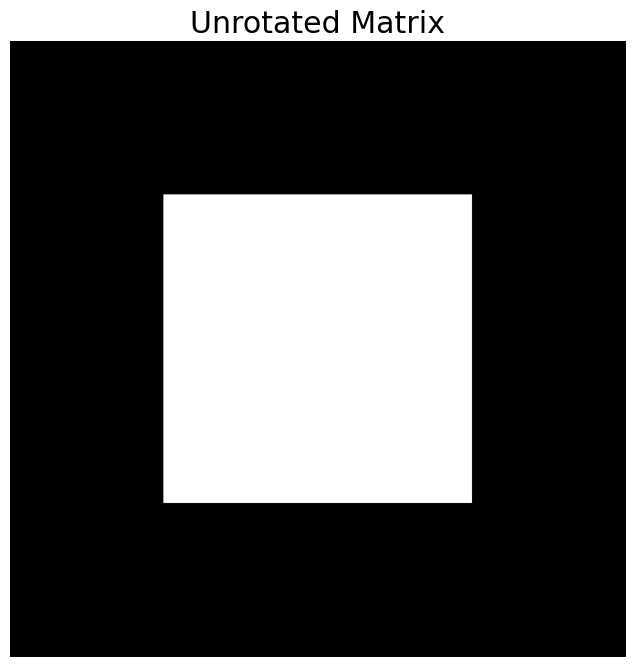

In [29]:
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 18})

n = 1000
q = int(n/4)
X = np.zeros((n,n))
X[(q-1):(3*q),(q-1):(3*q)] = 1

plt.imshow(X)
plt.set_cmap('gray')
plt.axis('off')
plt.title('Unrotated Matrix')
plt.show()


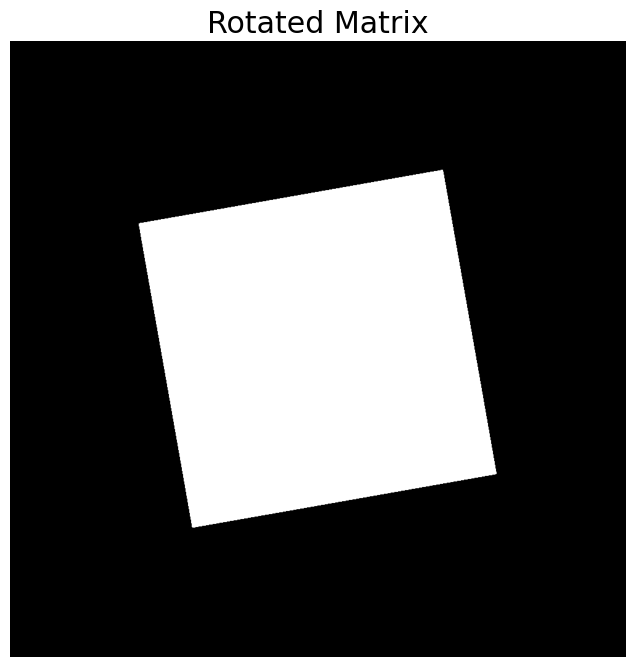

In [30]:
X_rot = skimage.transform.rotate(X,10)
X_rot[np.nonzero(X_rot)] = 1


plt.imshow(X_rot)
plt.set_cmap('gray')
plt.axis('off')
plt.title('Rotated Matrix')
plt.show()

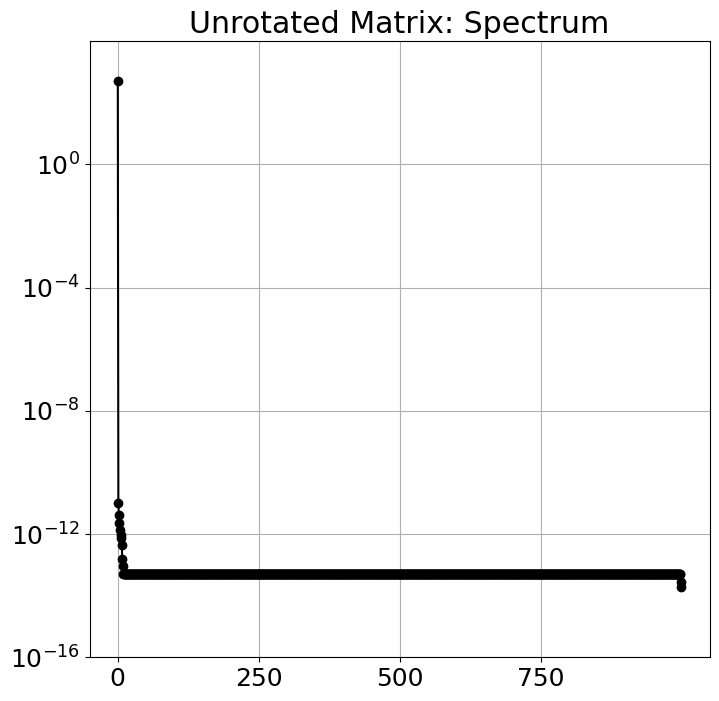

In [31]:
U, S, VT = np.linalg.svd(X,full_matrices=0)


plt.semilogy(S,'-o',color='k')
plt.ylim((10**(-16),10**(4)+1))
plt.yticks(np.power(10,np.arange(-16,4,4, dtype=float)))
plt.xticks(np.arange(0,1000,250))
plt.grid()
plt.title('Unrotated Matrix: Spectrum')
plt.show()

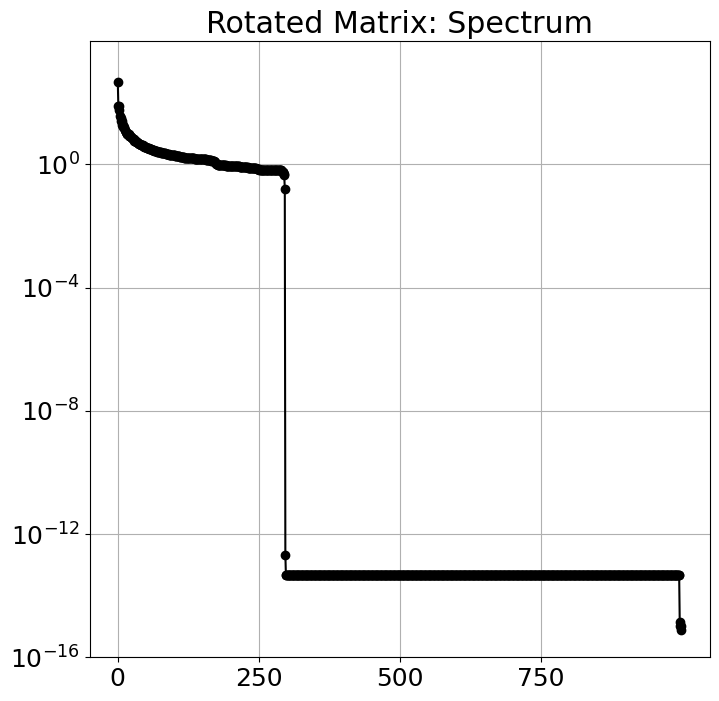

In [32]:
U_rot, S_rot, VT_rot = np.linalg.svd(X_rot,full_matrices=0)

plt.semilogy(S_rot,'-o',color='k')
plt.ylim((10**(-16),10**(4)+1))
plt.yticks(np.power(10,np.arange(-16,4,4, dtype=float)))
plt.xticks(np.arange(0,1000,250))
plt.grid()
plt.title('Rotated Matrix: Spectrum')
plt.show()

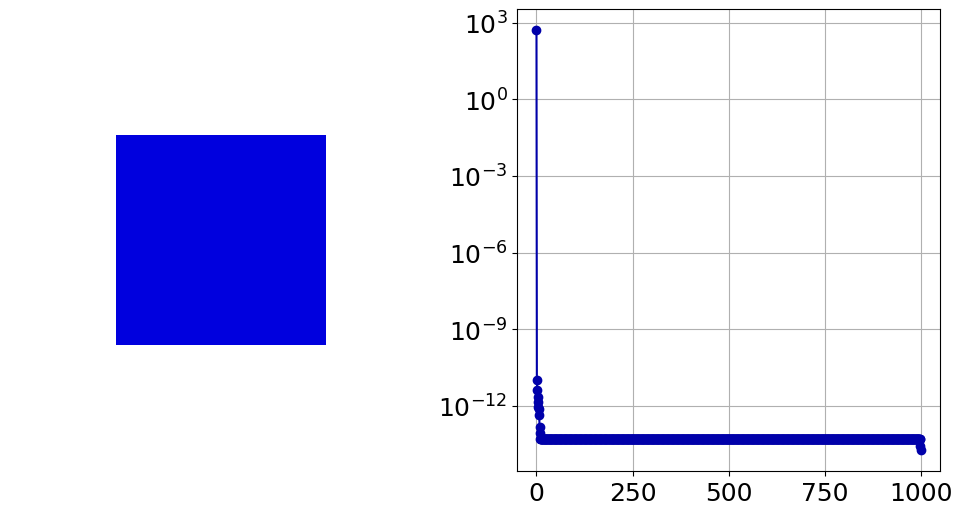

In [33]:
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 18})

n = 1000
q = int(n/4)
X = np.zeros((n,n))
X[(q-1):(3*q),(q-1):(3*q)] = 1

nAngles = 12 # Sweep through 12 different angles, from 0:4:44 degrees
cm_np = np.array([[0,0,2/3],
                 [0,0,1],
                 [0,1/3,1],
                 [0,2/3,1],
                 [0,1,1],
                 [1/3,1,2/3],
                 [2/3,1,1/3],
                 [1,1,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,0,0],
                 [2/3,0,0]])


cmap = plt.cm.jet
cmap.set_bad(alpha = 0.0)

U, S, VT = np.linalg.svd(X,full_matrices=0)

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
plt.imshow(np.ma.masked_where(X == 0, X),vmin=0,vmax=nAngles)
plt.set_cmap(cmap)
plt.axis('off')


ax2 = fig1.add_subplot(122)
plt.semilogy(S,'-o',color=tuple(cm_np[0]))
plt.grid()

plt.show()

/tmp/ipykernel_30115/768308675.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[1].axis('on')


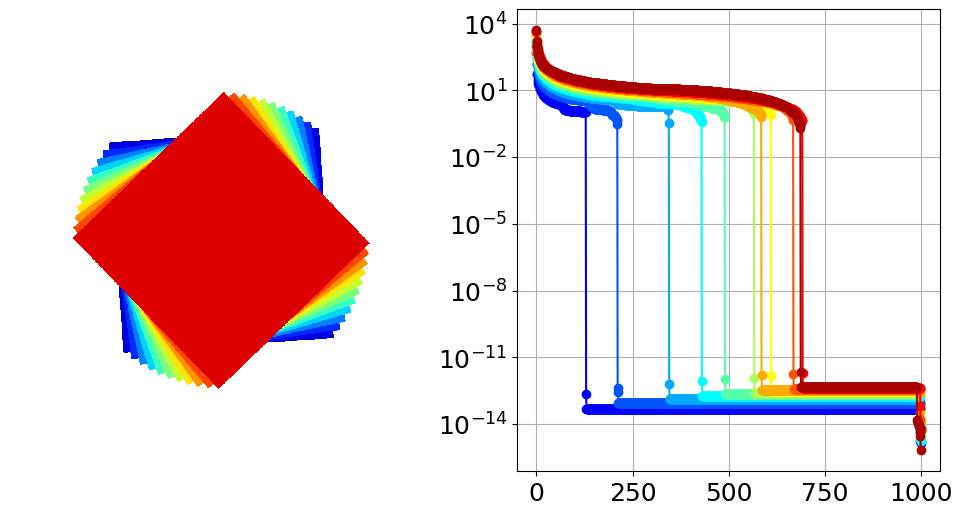

In [34]:
Xrot = X

fig, axs = plt.subplots(1,2)

for j in range(nAngles):
    Xrot = skimage.transform.rotate(X,j*4) #rotate by theta = j*4 degrees
    Xrot[np.nonzero(Xrot)] = j
    
    U, S, VT = np.linalg.svd(Xrot)

    axs[0].imshow(np.ma.masked_where(Xrot == 0, Xrot),vmin=0,vmax=nAngles)
    plt.set_cmap(cmap)
    axs[0].axis('off')

    axs[1].semilogy(S,'-o',color=tuple(cm_np[j]))
    axs[1].axis('on')
    axs[1].grid(1)

plt.show()